In [1]:
import timeit
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import os
import scipy.stats as stats
import tensorflow as tf
import matplotlib.pyplot as plt
import string
import nltk
import sklearn

from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from gensim.models import KeyedVectors
from sklearn.ensemble import RandomForestRegressor
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from transformers import AutoTokenizer, AutoModel, TFAutoModel
nltk.download('stopwords') # download stopwords corpus
nltk.download('punkt') # download punkt tokenizer



2023-06-10 10:43:18.961627: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Hannah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Hannah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/opt/anaconda3/envs/modelenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /Users/Hannah/Documents/VU/Msc/Thesis/Coding/Pipeline

/Users/Hannah/Documents/VU/Msc/Thesis/Coding/Pipeline


Some layers from the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline: Mean Squared Error: 0.11505407620392082
Baseline: Variance of Squared Errors: 0.017915251769198094
Baseline: STD of Squared Errors: 0.13384786800393234
Baseline: MSE Confidence Interval (10%, 90%): (0.11300167204939077, 0.11722702748660031)


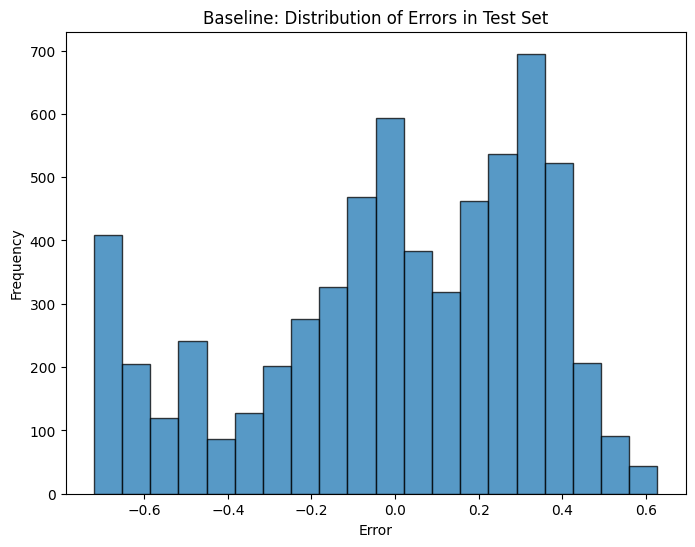

/var/folders/24/zyx78_1d5fndpjnbr8x7dd6r0000gn/T/ipykernel_96195/2798924811.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'embedding_{j}'] = embeddings[:, j]
/var/folders/24/zyx78_1d5fndpjnbr8x7dd6r0000gn/T/ipykernel_96195/2798924811.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'embedding_{j}'] = embeddings[:, j]
/var/folders/24/zyx78_1d5fndpjnbr8x7dd6r0000gn/T/ipykernel_96195/2798924811.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

Random Forest: Validation MSE: 0.12232106537775476
Random Forest: Test MSE (tuned): 0.12357100099495816
Random Forest: Variance of Errors: 0.1234006680526172
Random Forest: Standard Deviation of Errors: 0.35128431227798546
Random Forest: MSE Confidence Interval (10%, 90%): (0.1161533861640337, 0.130519918805034)


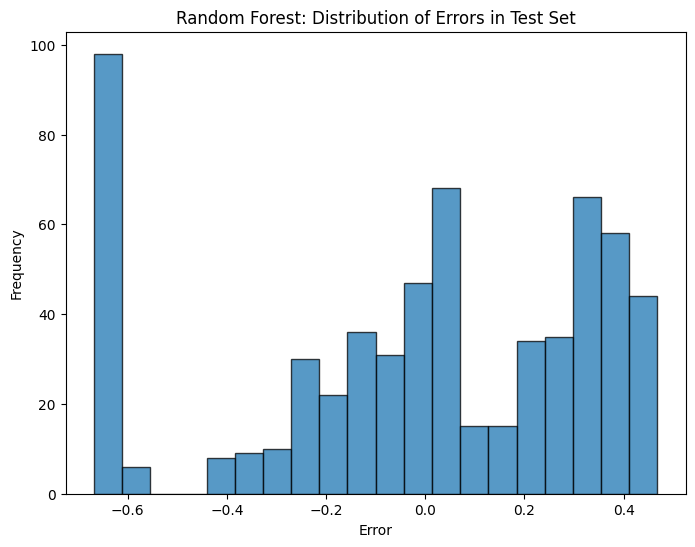

In [4]:
# Transformer for reading CSV file into DataFrame
class CSVReader(BaseEstimator, TransformerMixin):
    def __init__(self, file_path):
        self.file_path = file_path
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(self.file_path)
        
        # Return the DataFrame
        return df
    
# Transformer for Gensim Dutch Word2Vec embeddings
class GensimEmbeddings(BaseEstimator, TransformerMixin):
    def __init__(self, model_path, embedding_size):
        self.model_path = model_path
        self.embedding_size = embedding_size
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Load the Gensim Word2Vec model
        model = KeyedVectors.load_word2vec_format(self.model_path)
        
        # Initialize an empty numpy array to store the embeddings
        embeddings = np.zeros((len(X), self.embedding_size))
        
        # Iterate over the words in the text and calculate the embeddings
        for i, word in enumerate(X['prep_content']):
            if word in model:
                embeddings[i, :] = model[word]
            else:
                embeddings[i, :] = np.random.randn(self.embedding_size)
        
        # Add the embeddings to the DataFrame
        for j in range(embeddings.shape[1]):
            X[f'embedding_{j}'] = embeddings[:, j]
        
        return X

# Transformer for TFIDF embeddings
class TFIDFEmbeddings(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tfidf_vectorizer = TfidfVectorizer()
    
    def fit(self, X, y=None):
        self.tfidf_vectorizer.fit(X['prep_content'])
        return self
    
    def transform(self, X):
        # Fit the TF-IDF vectorizer if it's not fitted
        if not hasattr(self.tfidf_vectorizer, 'idf_'):
            self.fit(X)
        
        # Calculate the TF-IDF embeddings
        tfidf_embeddings = self.tfidf_vectorizer.transform(X['prep_content'])

        # Add the embeddings to the DataFrame
        for i in range(tfidf_embeddings.shape[1]):
            X[f'tfidf_embedding_{i}'] = tfidf_embeddings[:, i].toarray().flatten()
        
        n_features = len(self.tfidf_vectorizer.vocabulary_)

        return X, n_features
    
class BERTEmbeddings(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
        self.model = TFAutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # Tensorflow
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        embeddings = np.zeros((len(X), 768))
        for i, text in enumerate(X['content']):
            input_ids = self.tokenizer.encode(str(text), add_special_tokens=True, return_tensors="tf")
            output = self.model(input_ids)
            embeddings[i] = np.max(output.last_hidden_state.numpy(), axis=1)
        
        for j in range(embeddings.shape[1]):
            X[f'embedding_{j}'] = embeddings[:, j]
        
        return X  
       
# Transformer for baseline model   
class BaselineAnalysis(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        avg_entropy_per_source = X.groupby('name')['entropy'].mean()
        X['avg_entropy'] = X['name'].map(avg_entropy_per_source)

        mse = mean_squared_error(X['entropy'], X['avg_entropy'])
        print("Baseline: Mean Squared Error:", mse)

        errors = X['entropy'] - X['avg_entropy']
        squared_errors = errors ** 2
        variance = np.var(squared_errors)
        print("Baseline: Variance of Squared Errors:", variance)

        std = np.std(squared_errors)
        print("Baseline: STD of Squared Errors:", std)
        
        # Bootstrapping to calculate confidence intervals around MSE
        n_iterations = 1000  # Number of bootstrap iterations
        mse_bootstrapped = []
        for _ in range(n_iterations):
            # Resample the squared errors
            resampled_errors = np.random.choice(squared_errors, size=len(squared_errors), replace=True)
            # Calculate MSE from resampled errors
            mse_bootstrapped.append(np.mean(resampled_errors))

        # Calculate the lower and upper percentiles for confidence interval
        lower_percentile = 10  # 2.5th percentile
        upper_percentile = 90  # 97.5th percentile
        ci_lower = np.percentile(mse_bootstrapped, lower_percentile)
        ci_upper = np.percentile(mse_bootstrapped, upper_percentile)
        print(f"Baseline: MSE Confidence Interval ({lower_percentile}%, {upper_percentile}%): ({ci_lower}, {ci_upper})")

        plt.figure(figsize=(8, 6))
        plt.hist(errors, bins=20, edgecolor='black', alpha=0.75)
        plt.xlabel('Error')
        plt.ylabel('Frequency')
        plt.title('Baseline: Distribution of Errors in Test Set')
        plt.show()

        return X 
    
# Transformer for Random Forest
class RFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, embedding_option):
        self.embedding_option = embedding_option
        self.embedding_step = None
        self.xgboost_model = None
        self.y = None
    
    def fit(self, X, y= None):
        if self.embedding_option == 'gensim':
            self.embedding_step = GensimEmbeddings(model_path='/Users/Hannah/Downloads/160/combined-160.txt', embedding_size=160)
            X = self.embedding_step.transform(X)
            # Prepare the input features
            X_features = X.iloc[:, -160:]
        elif self.embedding_option == 'tfidf':
            self.embedding_step = TFIDFEmbeddings()
            X, n_features = self.embedding_step.transform(X)
            X_features = X.iloc[:, -n_features:]
        elif self.embedding_option == 'bert':
            self.embedding_step = BERTEmbeddings()
            X = self.embedding_step.transform(X)
            # Prepare the input features
            X_features = X.iloc[:, -768:]
        
        # In the first step we will split the data in training and remaining dataset
        y_target = X['entropy']
        self.y = y_target
        self.X_train, self.X_rem, self.y_train, self.y_rem = train_test_split(X_features , y_target, train_size=0.8)

        # Now since we want the valid and test size to be equal (10% each of overall data). 
        # we have to define valid_size=0.5 (that is 50% of remaining data)

        self.X_valid, self.X_test, self.y_valid, self.y_test = train_test_split(self.X_rem, self.y_rem, test_size=0.5)
        
        self.rf_model = RandomForestRegressor(random_state=42)
        self.rf_model.fit(self.X_train, self.y_train)

        # make predictions on validation set
        y_val_pred = self.rf_model.predict(self.X_valid)

        # evaluate performance on validation set
        val_mse = mean_squared_error(self.y_valid, y_val_pred)
        print("Random Forest: Validation MSE:", val_mse)
        
        # define the parameter grid to search
        param_grid = {
            'n_estimators': [50, 100, 150],
            'max_depth': [5, 10, 15],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 3, 4, 5]
        }
        # create a GridSearchCV object and fit it to the data
        grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
        grid_search.fit(self.X_train, self.y_train)

        # get the best model and print its hyperparameters
        self.rf_model = grid_search.best_estimator_

        return self
    
    def transform(self, X):
        if self.embedding_step is not None:
            X = self.embedding_step.transform(X)
        
        # evaluate the model on the test set
        y_pred = self.rf_model.predict(self.X_test)
        test_mse = mean_squared_error(self.y_test, y_pred)
        print("Random Forest: Test MSE (tuned):", test_mse)
        
        # Calculate the errors
        errors = self.y_test - y_pred
        
        # Calculate the variance and standard deviation of errors
        variance = np.var(errors)
        std = np.std(errors)
        print('Random Forest: Variance of Errors:', variance)
        print('Random Forest: Standard Deviation of Errors:', std)
        
        # Calculate the squared errors
        squared_errors = errors ** 2
        # Bootstrapping to calculate confidence intervals around MSE
        n_iterations = 1000  # Number of bootstrap iterations
        mse_bootstrapped = []
        for _ in range(n_iterations):
            # Resample the squared errors
            resampled_errors = np.random.choice(squared_errors, size=len(squared_errors), replace=True)
            # Calculate MSE from resampled errors
            mse_bootstrapped.append(np.mean(resampled_errors))

        # Calculate the lower and upper percentiles for confidence interval
        lower_percentile = 10  # 2.5th percentile
        upper_percentile = 90  # 97.5th percentile
        ci_lower = np.percentile(mse_bootstrapped, lower_percentile)
        ci_upper = np.percentile(mse_bootstrapped, upper_percentile)
        print(f"Random Forest: MSE Confidence Interval ({lower_percentile}%, {upper_percentile}%): ({ci_lower}, {ci_upper})")

        
        # Plot the distribution of errors
        plt.figure(figsize=(8, 6))
        plt.hist(errors, bins=20, edgecolor='black', alpha=0.75)
        plt.xlabel('Error')
        plt.ylabel('Frequency')
        plt.title('Random Forest: Distribution of Errors in Test Set')
        plt.show()
    
        return X

chosen_embedding = 'gensim'  

pipeline = Pipeline([
    ('csv_reader', CSVReader('Indicator-Desc_DataNewVanPipeline.csv')),
    ('baseline_analysis', BaselineAnalysis()),
    ('RF', RFTransformer(embedding_option=chosen_embedding)),
    
])

embedding_options = {
    'gensim': GensimEmbeddings(model_path='/Users/Hannah/Downloads/160/combined-160.txt', embedding_size=160),
    'tfidf': TFIDFEmbeddings(),
    'bert': BERTEmbeddings(),
}

pipeline.set_params(RF__embedding_option=chosen_embedding)
df_transformed = pipeline.fit_transform(None)